In [40]:
import lime
import sklearn
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn.metrics


Load data about wines' quality

In [41]:
data = pd.read_csv('../data/WINE/winequality-red.csv', sep = ';')
tr_data, ts_data = sklearn.model_selection.train_test_split(data, train_size=0.80)
labels_column_name = 'quality'
tr_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1408,8.1,0.29,0.36,2.2,0.048,35.0,53.0,0.99500,3.27,1.01,12.4,7
1054,8.2,0.64,0.27,2.0,0.095,5.0,77.0,0.99747,3.13,0.62,9.1,6
696,7.0,0.65,0.02,2.1,0.066,8.0,25.0,0.99720,3.47,0.67,9.5,6
939,6.2,0.46,0.17,1.6,0.073,7.0,11.0,0.99425,3.61,0.54,11.4,5
301,11.1,0.18,0.48,1.5,0.068,7.0,15.0,0.99730,3.22,0.64,10.1,6


Prepare data

In [42]:
tr_labels = np.array(tr_data[labels_column_name])
ts_labels = np.array(ts_data[labels_column_name])
tr_data_without_classes = tr_data.drop(labels_column_name, axis = 1)
ts_data_without_classes = ts_data.drop(labels_column_name, axis = 1)
training_set = np.array(tr_data_without_classes)
test_set = np.array(ts_data_without_classes)
attributes = list(tr_data_without_classes)
labels = data[labels_column_name].unique()
labels.sort()
print('Labels: ', labels)
print('Attributes: ', attributes)

Labels:  [3 4 5 6 7 8]
Attributes:  ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


Train random forest on prepared training dataset

In [43]:
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 800) # TODO use regressor!
random_forest.fit(training_set, tr_labels)

RandomForestClassifier(n_estimators=800)

Check forest quality with F-measure

In [44]:
sklearn.metrics.accuracy_score(ts_labels, random_forest.predict(test_set))

0.703125

### Next, explain something using lime

In [45]:
import lime
import lime.lime_tabular

Create explainer object (it need to be trained on startup)

In [46]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_set,
    feature_names = attributes,
    class_names = labels
)

Show probabilities for random instance (given by random forest on test dataset)

In [47]:
# random_indx = np.random.randint(0, test_set.shape[0])
# print(random_indx)
random_indx = 50
instance = test_set[random_indx].copy()
probabilities = random_forest.predict_proba(instance.reshape(1,-1))[0,:]
probabilities_for_labels = {}
for label, probability in zip(random_forest.classes_, probabilities):
    probabilities_for_labels.setdefault(label, []).append(probability)
print(probabilities_for_labels)

{3: [0.1325], 4: [0.31375], 5: [0.34], 6: [0.18375], 7: [0.03], 8: [0.0]}


Explain the instance

In [48]:
exp = explainer.explain_instance(
    test_set[random_indx],
    random_forest.predict_proba,
    num_features = 5,
    top_labels = 2
)
# exp.show_in_notebook(show_table=True, show_all=False)
exp.save_to_file('tmp/PoC_2.html')

In [49]:
exp.as_map()

{1: [(9, 0.036275890433175195),
  (1, 0.03370385496512335),
  (8, 0.013096303351865648),
  (5, 0.012518100203185271),
  (3, 0.011642897207096273)],
 2: [(9, 0.12396742147258427),
  (1, 0.06906166811768981),
  (10, -0.0627273578326701),
  (6, -0.04933458621242057),
  (7, 0.025975647550675985)]}

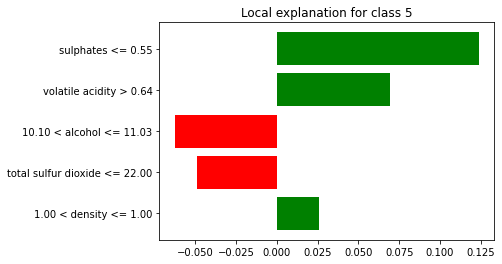

In [50]:
_ = exp.as_pyplot_figure(label=2)

In [51]:
exp.as_map()[2]

[(9, 0.12396742147258427),
 (1, 0.06906166811768981),
 (10, -0.0627273578326701),
 (6, -0.04933458621242057),
 (7, 0.025975647550675985)]

Update some attribute to see if probabilites would change

In [52]:
temp = test_set[random_indx]                # shallow copy!
print('P(quality = 5) before:', random_forest.predict_proba(temp.reshape(1,-1))[0,2])
print('P(quality = 6) before:', random_forest.predict_proba(temp.reshape(1,-1))[0,3])
temp[attributes.index('alcohol')] = 12.0    # update attribute: alcohol
print('P(quality = 5) after change:', random_forest.predict_proba(temp.reshape(1,-1))[0,2])
print('P(quality = 6) after change:', random_forest.predict_proba(temp.reshape(1,-1))[0,3])

P(quality = 5) before: 0.34
P(quality = 6) before: 0.18375
P(quality = 5) after change: 0.345
P(quality = 6) after change: 0.25375


Explain changed instance to see the changes

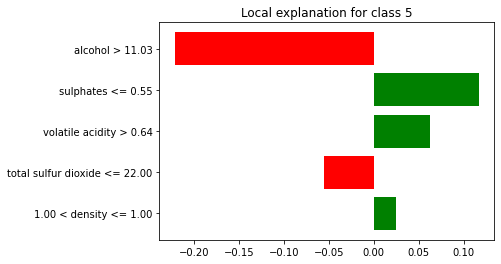

In [58]:
exp = explainer.explain_instance(
    test_set[random_indx],
    random_forest.predict_proba,
    num_features = 5,
    top_labels = 2
)
_ = exp.as_pyplot_figure(label=2)
